# BYOL Merger Classification Analysis

Clean, refactored notebook for analyzing BYOL embeddings and classifying galaxy mergers.

This notebook:
1. Loads trained BYOL model and embeddings
2. Applies PCA and UMAP dimensionality reduction
3. Performs K-NN based label propagation
4. Identifies merger candidates
5. Creates visualizations and analysis plots

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add pieridae to path
sys.path.insert(0, str(Path.cwd().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import pickle
from tqdm import tqdm

from pieridae.starbursts.byol import (
    BYOLModelManager,
    EmbeddingAnalyzer,
    LabelPropagation,
    load_merian_images
)

# Plotting utilities
from ekfplot import plot as ek, colors as ec
from matplotlib import colors

print("✅ Imports complete")

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


✅ Imports complete


## Load Configuration

In [2]:
# Load config
config_path = '../config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

config['data']['input_path'] = Path(config['data']['input_path'])
config['data']['output_path'] = Path(config['data']['output_path'])

print(f"📋 Configuration loaded")
print(f"   Input: {config['data']['input_path']}")
print(f"   Output: {config['data']['output_path']}")

📋 Configuration loaded
   Input: ../../local_data/pieridae_output/starlet/msorabove_v0
   Output: ../output


## Load Data and Embeddings

In [3]:
# Load images
print("Loading images...")
images, img_names = load_merian_images(config['data']['input_path'])
print(f"✅ Loaded {len(images)} images with shape {images.shape}")

Loading images...


Found 22913 image files
Counting valid images...
Validating files: 100%|██████████████| 22913/22913 [00:00<00:00, 87788.98it/s]
Found 22913 valid image sets
Loading images: 100%|██████████████████| 22913/22913 [00:37<00:00, 608.93it/s]
Loaded 22913 images with shape: (22913, 3, 150, 150)


✅ Loaded 22913 images with shape (22913, 3, 150, 150)


In [4]:
# Load or extract embeddings
output_path = config['data']['output_path']
embeddings_file = output_path / 'embeddings.npy'

if embeddings_file.exists():
    print("Loading existing embeddings...")
    embeddings = np.load(embeddings_file)
else:
    print("Extracting embeddings from trained model...")
    model_manager = BYOLModelManager(config, output_path)
    embeddings = model_manager.extract_embeddings(images)

print(f"✅ Embeddings shape: {embeddings.shape}")

Loading existing embeddings...
✅ Embeddings shape: (22913, 512)


## Dimensionality Reduction

In [5]:
# Compute PCA
print("Computing PCA...")
analyzer = EmbeddingAnalyzer(config)
embeddings_pca = analyzer.compute_pca(embeddings)

explained_var = analyzer.pca.explained_variance_ratio_.sum() * 100
print(f"✅ PCA complete: {analyzer.pca.n_components_} components")
print(f"   Explained variance: {explained_var:.1f}%")

2025-10-14 11:52:57,897 - INFO - Computing PCA...


Computing PCA...


2025-10-14 11:52:58,115 - INFO - PCA components: 10
2025-10-14 11:52:58,115 - INFO - Explained variance: 86.0%


✅ PCA complete: 10 components
   Explained variance: 86.0%


In [6]:
# Compute UMAP
print("Computing UMAP...")
embeddings_umap = analyzer.compute_umap(embeddings_pca)
print(f"✅ UMAP complete: shape {embeddings_umap.shape}")

2025-10-14 11:52:58,155 - INFO - Computing UMAP...
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing UMAP...
UMAP(min_dist=0.01, n_jobs=1, random_state=42, verbose=True)
Tue Oct 14 11:52:58 2025 Construct fuzzy simplicial set
Tue Oct 14 11:52:58 2025 Finding Nearest Neighbors
Tue Oct 14 11:52:58 2025 Building RP forest with 13 trees
Tue Oct 14 11:53:01 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Tue Oct 14 11:53:05 2025 Finished Nearest Neighbor Search
Tue Oct 14 11:53:06 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


2025-10-14 11:53:16,123 - INFO - UMAP embedding shape: (22913, 2)


Tue Oct 14 11:53:16 2025 Finished embedding
✅ UMAP complete: shape (22913, 2)


## Load Classification Labels

In [7]:
# Load labels
label_file = Path(config.get('labels', {}).get('classifications_file', ''))

if label_file.exists():
    mergers = pd.read_csv(label_file, index_col=0)
    labels = mergers.reindex(img_names)
    labels = labels.replace(np.nan, 0).values.flatten().astype(int)
    
    print(f"✅ Loaded {len(labels)} labels")
    
    # Print distribution
    label_meanings = config.get('labels', {}).get('label_mapping', {})
    unique, counts = np.unique(labels, return_counts=True)
    
    print("\n📊 Label distribution:")
    for label_val, count in zip(unique, counts):
        meaning = label_meanings.get(label_val, f"unknown_{label_val}")
        print(f"   {label_val} ({meaning}): {count} objects")
else:
    print(f"⚠️  Label file not found: {label_file}")
    labels = np.zeros(len(img_names), dtype=int)

✅ Loaded 22913 labels

📊 Label distribution:
   0 (unclassified): 19960 objects
   1 (undisturbed): 2314 objects
   2 (ambiguous): 214 objects
   3 (merger): 96 objects
   4 (fragmentation): 280 objects
   5 (artifact): 49 objects


## K-NN Label Propagation

In [1]:
2314 + 214 + 96 + 280 + 49

2953

In [9]:
# Initialize label propagation
n_min = config.get('labels', {}).get('minimum_labeled_neighbors', 5)
n_min_auto = config.get('labels', {}).get('minimum_labeled_neighbors_for_autoprop', 15)
print(f"Using minimum_labeled_neighbors_for_autoprop = {n_min_auto}")

print(f"Using minimum_labeled_neighbors = {n_min}")

propagator = LabelPropagation(
    n_neighbors=50,
    n_min=n_min,
    n_min_auto=n_min_auto,
    prob_threshold=0.9,
    frag_threshold=0.1,
)

# Run iterative propagation
print("\nRunning iterative label propagation...")
iterative_labels, n_labels_iter, prob_labels_iter, stats = \
    propagator.iterative_propagation(embeddings_pca, labels)

print(f"\n✅ Label propagation complete")
print(f"   Human labels: {stats['n_human']}")
print(f"   Auto-labels added: {stats['n_added_iteration']}")
print(f"   Total labels: {stats['n_final_auto']}")

2025-10-14 11:53:16,290 - INFO - 
Starting iterative label estimation...
2025-10-14 11:53:16,291 - INFO - Finding 50 nearest neighbors...


Using minimum_labeled_neighbors_for_autoprop = 15
Using minimum_labeled_neighbors = 5

Running iterative label propagation...


2025-10-14 11:53:17,650 - INFO - Human labels: 2953
/Users/kadofong/work/projects/merian/pieridae/pieridae/starbursts/byol.py:698: RuntimeWarning: invalid value encountered in divide
  weights /= np.nansum(weights, axis=1).reshape(-1, 1)
2025-10-14 11:53:17,673 - INFO - 15493 objects have auto-labels
2025-10-14 11:53:17,674 - INFO - 7420 objects have fewer than 5 labeled neighbors
2025-10-14 11:53:17,675 - INFO - Initial auto-labels: 15493 objects have potential probabilistic labels
2025-10-14 11:53:17,675 - INFO - Added 311 auto-labels in first iteration
2025-10-14 11:53:17,676 - INFO - Total labels after iteration: 3264
2025-10-14 11:53:17,676 - INFO - 
Recalculating with expanded label set...
2025-10-14 11:53:17,700 - INFO - 17059 objects have auto-labels
2025-10-14 11:53:17,701 - INFO - 5854 objects have fewer than 5 labeled neighbors
2025-10-14 11:53:17,702 - INFO - After second iteration: 17059 objects have auto-labels



✅ Label propagation complete
   Human labels: 2953
   Auto-labels added: 311
   Total labels: 17059


## Identify Merger Candidates

In [10]:
# Identify mergers based on probability labels
fragmented = prob_labels_iter[:, 4] > 0.3
possible_merger = (prob_labels_iter[:, 2] + prob_labels_iter[:, 3]) > prob_labels_iter[:, 1]

is_merger = possible_merger & ~fragmented

print(f"📊 Merger identification:")
print(f"   Fragmented objects: {fragmented.sum()}")
print(f"   Possible mergers: {possible_merger.sum()}")
print(f"   Merger candidates (excluding fragmented): {is_merger.sum()}")

📊 Merger identification:
   Fragmented objects: 1795
   Possible mergers: 1283
   Merger candidates (excluding fragmented): 556


## Visualizations

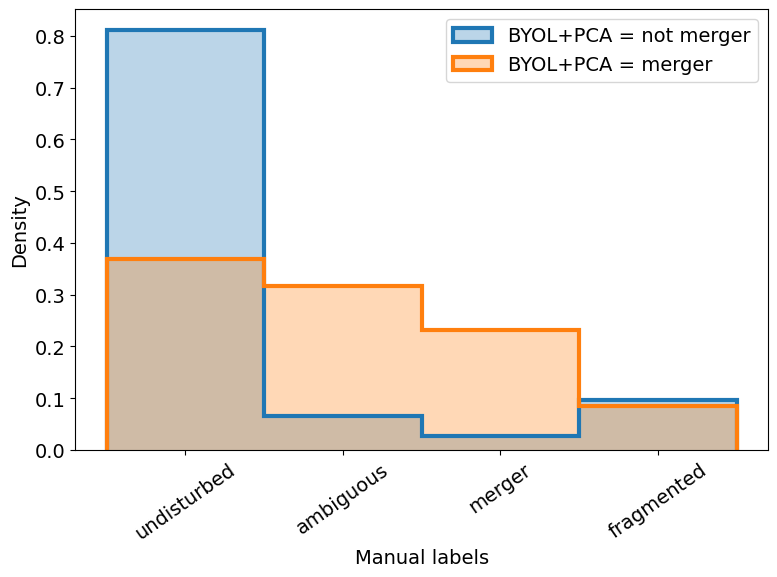

In [30]:
# Compare with manual labels
if (labels > 0).any():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Create contingency table
    manual_merger = (labels == 3) | (labels == 2)  # merger or ambiguous
    manual_nonmerger = labels == 1  # undisturbed
    
    hist_kwargs = {'alpha': 0.3, 'lw': 3, 'bins': np.arange(0.5, 5.5), 'density': True}
    
    ek.hist(labels[~is_merger], ax=ax, label='BYOL+PCA = not merger', **hist_kwargs)
    ek.hist(labels[is_merger], ax=ax, label='BYOL+PCA = merger', **hist_kwargs)
    
    ax.set_xticks(np.arange(1,5),['undisturbed', 'ambiguous', 'merger', 'fragmented'], rotation=35)
    ax.set_xlabel('Manual labels')
    ax.set_ylabel('Density')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

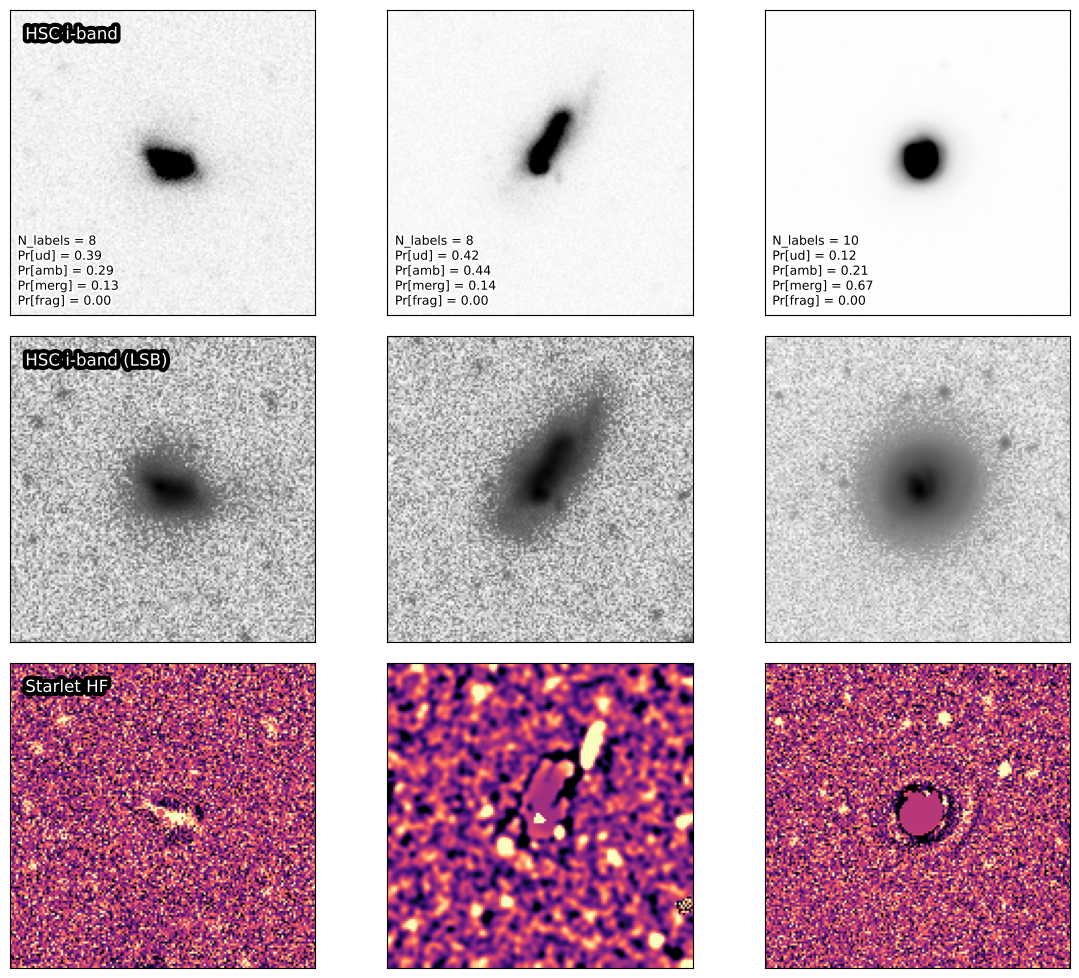

In [36]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[possible_merger & ~fragmented & manual_nonmerger]
n_examples = min(3, len(candidates))

if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(12, 10))
    
    for idx, gix in enumerate(example_indices):
        # i-band
        ek.imshow(images[gix][1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            images[gix][1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(images[gix][2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
else:
    print("No merger candidates found")

## Example Merger Candidates

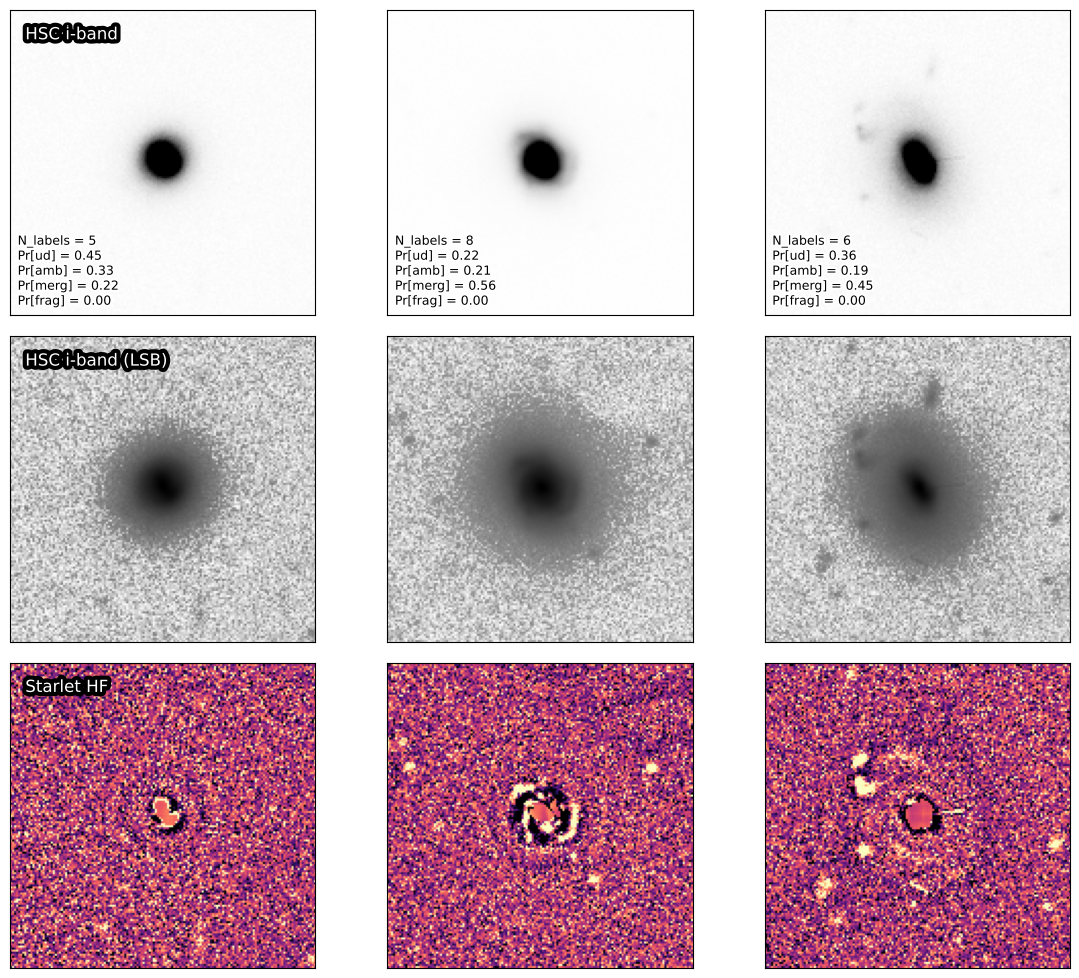

In [34]:
# Show examples of merger candidates
candidates = np.arange(len(img_names))[possible_merger & ~fragmented]
n_examples = min(3, len(candidates))

if n_examples > 0:
    example_indices = np.random.choice(candidates, n_examples, replace=False)
    
    fig, axarr = plt.subplots(3, n_examples, figsize=(12, 10))
    
    for idx, gix in enumerate(example_indices):
        # i-band
        ek.imshow(images[gix][1], ax=axarr[0, idx], q=0.01, cmap='Greys')
        
        # i-band log scale
        axarr[1, idx].imshow(
            images[gix][1],
            origin='lower',
            cmap='Greys',
            norm=colors.SymLogNorm(linthresh=0.1)
        )
        
        # High-frequency
        ek.imshow(images[gix][2], ax=axarr[2, idx], cmap='magma')
        
        # Add statistics
        ek.text(
            0.025, 0.025,
            f"""N_labels = {n_labels_iter[gix]}
Pr[ud] = {prob_labels_iter[gix, 1]:.2f}
Pr[amb] = {prob_labels_iter[gix, 2]:.2f}
Pr[merg] = {prob_labels_iter[gix, 3]:.2f}
Pr[frag] = {prob_labels_iter[gix, 4]:.2f}""",
            ax=axarr[0, idx],
            fontsize=9,
            bordercolor='w',
            color='k',
            borderwidth=3
        )
    
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    
    ek.text(0.05, 0.95, 'HSC i-band', ax=axarr[0, 0], fontsize=12, 
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'HSC i-band (LSB)', ax=axarr[1, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    ek.text(0.05, 0.95, 'Starlet HF', ax=axarr[2, 0], fontsize=12,
            bordercolor='k', color='w', borderwidth=6)
    
    plt.tight_layout()
    plt.show()
else:
    print("No merger candidates found")

## Save Results

In [ ]:
# Save analysis results
results = {
    'img_names': img_names,
    'embeddings_pca': embeddings_pca,
    'embeddings_umap': embeddings_umap,
    'labels': labels,
    'iterative_labels': iterative_labels,
    'prob_labels': prob_labels_iter,
    'n_labels': n_labels_iter,
    'is_merger': is_merger,
    'is_fragmented': fragmented
}

results_file = output_path / 'merger_analysis_results.pkl'
with open(results_file, 'wb') as f:
    pickle.dump(results, f)

print(f"✅ Results saved to: {results_file}")